In [1]:
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

In [2]:
def plot_steps(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        iteration = data.iloc[runIdx]["iteration"]
        clusters = data.iloc[runIdx]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters))
        print("iteration: %s, clusters: %s" % (iteration, len(clusters)))
        for cIdx in range(0, len(clusters)):
            rgba_color = cm.gnuplot(norm(cIdx))
            pointsX = [point[0] for point in clusters[cIdx]["points"]]
            pointsY = [point[1] for point in clusters[cIdx]["points"]]
            ax.scatter(pointsX, pointsY, color=rgba_color)
            ax.scatter(clusters[cIdx]["centroid"][0], clusters[cIdx]["centroid"][1], color=rgba_color, marker="+")

        plt.show()

In [3]:
def plot(data):
    for runIdx in range(0, len(data)):
        fig, ax = plt.subplots()
        clusters_step1 = data.iloc[runIdx]["steps"][0]["clusters"]
        clusters_step2 = data.iloc[runIdx]["steps"][1]["clusters"]
        norm = colors.Normalize(vmin=0, vmax=len(clusters_step1))
        for cIdx in range(0, len(clusters_step1)):
            rgba_color = cm.gnuplot(norm(cIdx))
            ax.plot(clusters_step1[cIdx]["syntheticCenter"], "--", color=rgba_color, label="cluster %s" % cIdx)
            ax.plot(clusters_step2[cIdx]["syntheticCenter"], color=rgba_color, label="cluster %s - rescheduled" % cIdx)
            print(clusters_step2[cIdx]["metric"])
        ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)

        ax.set(xlabel='Hours', ylabel='Power (kW)',title='')
        plt.show()

In [15]:
def plot_aggm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. agg m"], "--", color=rgba_color, label="s1. agg m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. agg m"], color=rgba_color, label="s2. agg m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_maxm(summary, file_name=None): 
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. max m"], "--", color=rgba_color, label="s1. max m")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. max m"], color=rgba_color, label="s2. max m")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Max. Aggregate PAR',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig
    
def plot_peak(summary, file_name=None):
    fig, ax = plt.subplots()
    rgba_color = cm.gnuplot(norm(0))
    ax.plot(range(1, len(summary["s1. agg m"]) + 1), summary["s1. peak"], "--", color=rgba_color, label="s1. peak")
    ax.plot(range(1, len(summary["s2. agg m"]) + 1), summary["s2. peak"], color=rgba_color, label="s2. peak")
    lgd = ax.legend(bbox_to_anchor=(1, -0.3), loc=4, borderaxespad=0.)
    ax.set(xlabel='K clusters', ylabel='Peak power (kW)',title='')
    plt.show()
    if file_name is not None:
        fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

# PAR Aggregate

In [16]:
summaryBatch_global = pd.read_json("./files/scheduler_tests/scheduler_test_inverse/summaryBatch.json")
#summaryBatch_global = summaryBatch_global[["k","clusters","s1. agg m","s1. max m","s1. peak","s2. agg m","s2. max m","s2. peak","total m"]]
#batch_global = pd.read_json("./files/batch.json")

exp1_k = 6
exp1_sample_size_min = 0.5
exp1_sample_size_max = 1.0
exp1_nsteps = 2


def sample_size_range(sample_size_min, sample_size_max):
    return (x/10 for x in range(int(sample_size_min * 10), int((sample_size_max * 10) + 1)))

In [17]:
def crossfold_as_df(k, data):
    index_list = []
    step_list = []

    for i in range(0 , len(data)):
        register = data.iloc[i]

        crossfold = json_normalize(register["crossfold"])
        splits = crossfold["splits"].values[0]
        steps = data.iloc[i]["step"]
        for j in range(0, splits):
            step = json_normalize(steps[j])
            for ki in range(1, k+1):
                index_list.append((float("{0:.2f}".format(crossfold["sampleSize"].values[0])), j, ki))
                step_list.append(step.iloc[ki-1])


    json_normalize(data.iloc[0]["crossfold"])
    json_normalize(data.iloc[0]["step"][0])

    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "split", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_treated = crossfold_as_df(exp1_k, summaryBatch_global)
exp1_treated

k  s1. peak  s1. agg m  s1. max m  s1. total m  \
sampleSize split k                                                   
0.5        0     1  1    633455   2.165764   2.165764     2.165764   
                 2  2    323827   1.006218   2.179618     2.165764   
                 3  3    237717   1.047535   2.495463     2.165764   
                 4  4    263913   1.063988   2.749196     2.165764   
                 5  5    203198   1.061827   3.157455     2.165764   
...                ..       ...        ...        ...          ...   
1.0        1     2  2    624947   1.017601   2.004835     1.965393   
                 3  3    429895   1.010890   2.076331     1.965393   
                 4  4    467030   1.033548   2.281877     1.965393   
                 5  5    344100   1.038269   2.365162     1.965393   
                 6  6    293367   1.074581   2.630383     1.965393   

                                clusters  s2. peak  s2. agg m  s2. max m  \
sampleSize split k                                                         
0.5        0     1                  [25]    633455   2.165764   2.165764   
                 2              [10, 15]    370859   1.096145   2.610652   
                 3            [7, 10, 8]    237717   1.042633   2.495463   
                 4          [8, 5, 8, 4]    263913   1.324216   3.843335   
                 5       [6, 6, 4, 3, 6]    203198   1.115361   3.157455   
...                                  ...       ...        ...        ...   
1.0        1     2              [28, 22]    669194   1.081256   2.146780   
                 3          [16, 19, 15]    444467   1.062090   2.117517   
                 4        [20, 9, 13, 8]    415881   1.044108   2.188124   
                 5     [16, 14, 7, 7, 6]    388991   1.213517   2.877759   
                 6  [10, 10, 9, 8, 9, 4]    317215   1.084616   2.532128   

                    s2. total m  
sampleSize split k               
0.5        0     1     2.165764  
                 2     2.165764  
                 3     2.165764  
                 4     2.165764  
                 5     2.165764  
...                         ...  
1.0        1     2     1.842278  
                 3     1.842278  
                 4     1.842278  
                 5     1.842278  
                 6     1.842278  

[72 rows x 10 columns]

In [18]:
k2 = 2
query = f"k == {k2} and sampleSize == {exp1_sample_size_min}"
exp1_treated.query(query)["s1. agg m"].mean()
exp1_treated.query(query)["s1. max m"].mean()
exp1_treated.query(query)["s1. peak"].std()

46659.85517015671

In [19]:
def get_statistics(k, nSteps, treated, sample_size_min, sample_size_max):
    index_list = []
    step_list = []

    for j in range(1, k+1):
        for ssize in sample_size_range(sample_size_min, sample_size_max):

            index_list.append((ssize, "mean", j))
            query = f"k == {j} and sampleSize == {ssize}"
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            data = {key: treated.query(query)[key].mean() for key in index}
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].mean(),
                    "s1. max m" : treated.query(query)["s1. max m"].mean(), 
                    "s1. peak" : treated.query(query)["s1. peak"].mean()/1000,
                   "s1. total m" : treated.query(query)["s1. total m"].mean()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].mean(),
                    "s2. max m" : treated.query(query)["s2. max m"].mean(), 
                    "s2. peak" : treated.query(query)["s2. peak"].mean()/1000,
                            "s2. total m" : treated.query(query)["s2. total m"].mean()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)
            #print(f"sampleSize = {ssize}, k = {j}")

            index_list.append((ssize, "stdv", j))
            query = f"k == {j} and sampleSize == {ssize}"
            data = {"s1. agg m" : treated.query(query)["s1. agg m"].std(),
                    "s1. max m" : treated.query(query)["s1. max m"].std(), 
                    "s1. peak" : treated.query(query)["s1. peak"].std(),
                   "s1. total m" : treated.query(query)["s1. total m"].std()}
            index = ["s1. agg m","s1. max m","s1. peak", "s1. total m"]
            if (nSteps >= 2):
                data.update({"s2. agg m" : treated.query(query)["s2. agg m"].std(),
                    "s2. max m" : treated.query(query)["s2. max m"].std(), 
                    "s2. peak" : treated.query(query)["s2. peak"].std(),
                            "s2. total m" : treated.query(query)["s2. total m"].std()})
                index = index + ["s2. agg m","s2. max m","s2. peak", "s2. total m"]

            s = pd.Series(data,index=index) 
            step_list.append(s)


    index = pd.MultiIndex.from_tuples(index_list, names=["sampleSize", "metric", "k"])
    return pd.DataFrame(step_list, index=index)
exp1_statistics = get_statistics(exp1_k,exp1_nsteps, exp1_treated, exp1_sample_size_min, exp1_sample_size_max)
exp1_statistics

s1. agg m  s1. max m      s1. peak  s1. total m  \
sampleSize metric k                                                    
0.5        mean   1   2.014717   2.014717    667.680500     2.014717   
           stdv   1   0.213613   0.213613  48402.166279     0.213613   
0.6        mean   1   1.870394   1.870394    730.583500     1.870394   
           stdv   1   0.034070   0.034070  40666.418093     0.034070   
0.7        mean   1   2.051708   2.051708    796.259000     2.051708   
...                        ...        ...           ...          ...   
0.8        stdv   6   0.012797   0.016739   4618.821495     0.159189   
0.9        mean   6   1.096683   2.762835    292.979500     1.911760   
           stdv   6   0.005973   0.044319   3894.037044     0.117191   
1.0        mean   6   1.075847   2.519685    286.232500     1.965393   
           stdv   6   0.001791   0.156550  10089.706661     0.000000   

                     s2. agg m  s2. max m      s2. peak  s2. total m  
sampleSize metric k                                                   
0.5        mean   1   1.920844   1.920844    632.325500     1.920844  
           stdv   1   0.346370   0.346370   1597.354219     0.346370  
0.6        mean   1   1.756148   1.756148    686.453000     1.756148  
           stdv   1   0.099601   0.099601  64582.890753     0.099601  
0.7        mean   1   1.833663   1.833663    711.699000     1.833663  
...                        ...        ...           ...          ...  
0.8        stdv   6   0.066085   0.426581    654.780879     0.052672  
0.9        mean   6   1.175340   2.998831    303.312000     1.847744  
           stdv   6   0.016338   0.013976  21296.642036     0.039819  
1.0        mean   6   1.095221   2.470558    320.338000     1.842278  
           stdv   6   0.014997   0.087073   4416.588955     0.000000  

[72 rows x 8 columns]

In [20]:
def get_metrics(k, metric, metric_type, statistics, sample_size_min, sample_size_max):

    index_list = [sample_size_range(sample_size_min, sample_size_max)]
    cols = [x for x in range(1, k+1)]
    step_list = []

    for ssize in sample_size_range(sample_size_min, sample_size_max):
        query = f"sampleSize == {ssize} and metric == \"{metric_type}\" "
        dataAllK = statistics.query(query)[f"{metric}"]
        dictAllK = {}
        for j in range(1, k+1):
            d = dataAllK.reset_index().query(f"k == {j}")[f"{metric}"]
            dictAllK[f"{j}"] = d.values[0]
        s = pd.Series(dictAllK, name=f"{ssize}")
        step_list.append(s)

    return pd.DataFrame(step_list)
    
mname = "s1. max m"
mtype = "stdv"
m = get_metrics(exp1_k, mname, mtype, exp1_statistics, exp1_sample_size_min, exp1_sample_size_max)

In [21]:
m

,1,2,3,4,5,6
0.5,0.213613,0.086044,0.041735,0.167641,0.406571,0.041920
0.6,0.034070,0.109760,0.078539,0.080564,0.228446,0.108315
0.7,0.100776,0.167377,0.240231,0.089290,0.058871,0.085465
0.8,0.159189,0.125072,0.055736,0.014213,0.042533,0.016739
0.9,0.117191,0.030698,0.097303,0.078047,0.108645,0.044319
1.0,0.000000,0.027625,0.012031,0.085441,0.008969,0.156550


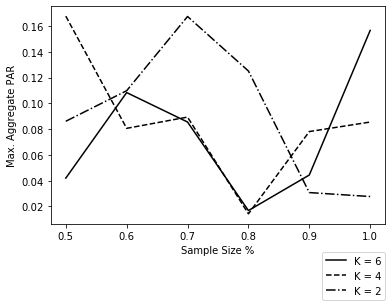

In [22]:
fig, ax = plt.subplots()

k2 = 6
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-", label=f"K = {k2}", c="black")

k2 = 4
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "--", label=f"K = {k2}", c="black")

k2 = 2
sampleMaxMDataset = m[str(k2)]
sampleSizes = list(map(lambda x: float(x), sampleMaxMDataset.index.values))
values = sampleMaxMDataset.values
ax.plot(sampleSizes, values, "-.", label=f"K = {k2}", c="black")

lgd = ax.legend(bbox_to_anchor=(1, -0.35), loc=4, borderaxespad=0.)
ax.set(xlabel='Sample Size %', ylabel='Max. Aggregate PAR',title='')
plt.show()
file_name = "peakpower_samplesize.pdf"
if file_name is not None:
    fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [23]:
def show_summary(k, summary_treated, statistics):
    _list = {}
    for j in range(1, k+1):
        _list[j - 1] = str(summary_treated.query(f"sampleSize == 1.0 and k == {j}").sort_values(by=["s1. max m", "s1. agg m"]).iloc[0]["clusters"])
    _list
    a = statistics.query("sampleSize == 1.0 and metric == \"mean\"").reset_index().drop(["sampleSize", "metric"], axis=1)
    b = pd.DataFrame.from_dict(_list, orient="index", columns=["clusters"])
    r = pd.concat([a,b], axis=1, sort=False)
    r = r[["k", "clusters", "s1. agg m", "s1. max m", "s1. peak", "s2. agg m", "s2. max m", "s2. peak", "s2. total m"]]
    return r

show_summary(exp1_k, exp1_treated, exp1_statistics)

,k,clusters,s1. agg m,s1. max m,s1. peak,s2. agg m,s2. max m,s2. peak,s2. total m
0,1,[50],1.965393,1.965393,1224.6870,1.842278,1.842278,1147.9710,1.842278
1,2,"[26, 24]",1.008893,1.985301,626.1300,1.040956,2.056274,647.9585,1.842278
2,3,"[22, 15, 13]",1.026393,2.067824,454.3425,1.052642,2.088417,464.1615,1.842278
3,4,"[20, 9, 13, 8]",1.027800,2.342293,473.1960,1.099426,2.505226,434.0120,1.842278
4,5,"[16, 14, 7, 7, 6]",1.053152,2.371504,376.0260,1.202803,2.825811,476.3640,1.842278
5,6,"[9, 7, 11, 6, 8, 9]",1.075847,2.519685,286.2325,1.095221,2.470558,320.3380,1.842278


In [24]:
get_metrics(exp1_k, "s1. agg m", "mean", exp1_statistics, exp1_sample_size_min, exp1_sample_size_max).iloc[-1]

1    1.965393
2    1.008893
3    1.026393
4    1.027800
5    1.053152
6    1.075847
Name: 1.0, dtype: float64

In [25]:
with open('summaryBatch.tex','w') as tf:
    tf.write(r.to_latex())

NameError: name 'r' is not defined